Created on Sunday, April 12, 2020

@author: Himanshu and Jamie

ASEN 5044 Statistical Estimation, Spring 2020 - Project report 1 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
from scipy.integrate import odeint
import pdb

In [2]:
#Initializations

x0 = np.array([10,0,np.pi/2,-60,0,-np.pi/2])
u = np.array([2, -np.pi/18, 12, np.pi/25])
v= np.zeros(5).reshape(5,1)
L = 0.5
num_time_steps = 400
delta_t = 0.1
time_steps = np.linspace(0, num_time_steps*delta_t, num_time_steps)


In [3]:
#Generate Nominal trajectory with no noise

def model(x, t, u, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g)
    dxdt[1] = v_g*np.sin(theta_g)
    dxdt[2] = (v_g/L)*np.tan(phi_g)
    dxdt[3] = v_a*np.cos(theta_a)
    dxdt[4] = v_a*np.sin(theta_a)
    dxdt[0] = w_a
    return dxdt

def calculate_exact_yt(x,v):
    
    temp = (x[4]-x[1])/(x[3]-x[0])
    y1 = np.arctan(temp) - x[2]
    y2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    y3 = np.arctan(temp) - x[5]
    y4 = x[3]
    y5 = x[4]
    
    yt = np.array([
                [y1],
                [y2],
                [y3],
                [y4],
                [y5]
                ])
    yt = yt + v
    return yt


nominal_state_trajectory = odeint(model, x0, time_steps, args = (u,L))
nominal_state_measurements = []
for i in range(0,len(nominal_state_trajectory)):
    nominal_state_measurements.append(calculate_exact_yt(nominal_state_trajectory[i],v))

In [4]:
def get_CT_Jacobians(x,u):
    
    A = np.array([
            [0, 0, -u[0]*np.sin(x[2]), 0, 0, 0],
            [0, 0, u[0]*np.cos(x[2]), 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -u[2]*np.sin(x[5])],
            [0, 0, 0, 0, 0, u[2]*np.cos(x[5])],
            [0, 0, 0, 0, 0, 0]])

    
    B = np.array([
            [np.cos(x[2]), 0, 0, 0],
            [np.sin(x[2]), 0, 0, 0],
            [np.tan(u[1])/L, u[0]/(L*(np.cos(u[1])**2)), 0, 0],
            [0, 0, np.cos(x[5]), 0],
            [0, 0, np.sin(x[5]), 0],
            [0, 0, 0, 1]
            ])    
    
    Ga = np.eye(6)
    
    denominator_1 = 1 + ((x[4]-x[1])/(x[3]-x[0]))**2
    numerator_11 = (x[4]-x[1]) / ((x[3] - x[0])**2)
    C11 = numerator_11/denominator_1
    
    numerator_12 = -1/(x[3]-x[0])
    C12 = numerator_12/denominator_1
    
    C14 = -1*C11
    C15 = -1*C12
    
    denominator_2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    C21 = (x[0]-x[3])/denominator_2
    C22 = (x[1]-x[4])/denominator_2
    C24 = -1*C21
    C25 = -1*C22
    
    C = np.array([
            [C11, C12, -1, C14, C15, 0],
            [C21, C22, 0, C24, C25, 0],
            [C11, C12, 0, C14, C15, -1],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0]
            ])

    D = 0
    
    return A,B, Ga, C, D

def get_DT_Jacobians(x,u,dt):
    
    A,B,Gamma,C,D = get_CT_Jacobians(x,u)
    
    F = np.eye(6) + dt*A
    G = dt*B
    Omega = delta_t*Gamma
    H = C
    M = D
    
    return F,G,Omega,H,M

In [5]:
def get_K_perturbations(initial_perturbation,nominal_state_trajectory,u,delta_t,K):
    
    delta_x0 = np.array(initial_perturbation).reshape(len(initial_perturbation),1) 
    delta_x_list = []
    delta_y_list = []
    delta_xk = delta_x0 
    delta_uk = np.zeros(4).reshape(4,1)
    for k in range(0,K):
        delta_x_list.append(delta_xk)
        xk_nominal = nominal_state_trajectory[k]
        uk_nominal = u
        Fk,Gk,Omegak,Hk,Mk = get_DT_Jacobians(xk_nominal,uk_nominal,delta_t)
        delta_xk_plus1 = np.dot(Fk,delta_xk) + np.dot(Gk,delta_uk)
        delta_yk = np.dot(Hk,delta_xk)
        delta_y_list.append(delta_yk)
        delta_xk = delta_xk_plus1
        
    return delta_x_list,delta_y_list

initial_perturbation = 0.05*np.ones(len(x0))
delta_x_list, delta_y_list = get_K_perturbations(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps)

In [6]:
linearized_DT_states = []
for k in range(0,len(nominal_state_trajectory)):
    xk = nominal_state_trajectory[k].reshape(len(nominal_state_trajectory[k]),1) + delta_x_list[k]
    linearized_DT_states.append(xk)
    
linearized_DT_measurements = []
for k in range(0,len(nominal_state_measurements)):
    yk = nominal_state_measurements[k] + delta_y_list[k]
    linearized_DT_measurements.append(yk)


In [7]:
non_linear_trajectory_with_perturbed_x0 = odeint(model, x0+initial_perturbation, time_steps, args = (u,L))
non_linear_measurements_with_perturbed_x0 = []
for i in range(0,len(non_linear_trajectory_with_perturbed_x0)):
    non_linear_measurements_with_perturbed_x0.append(calculate_exact_yt(non_linear_trajectory_with_perturbed_x0[i],v))

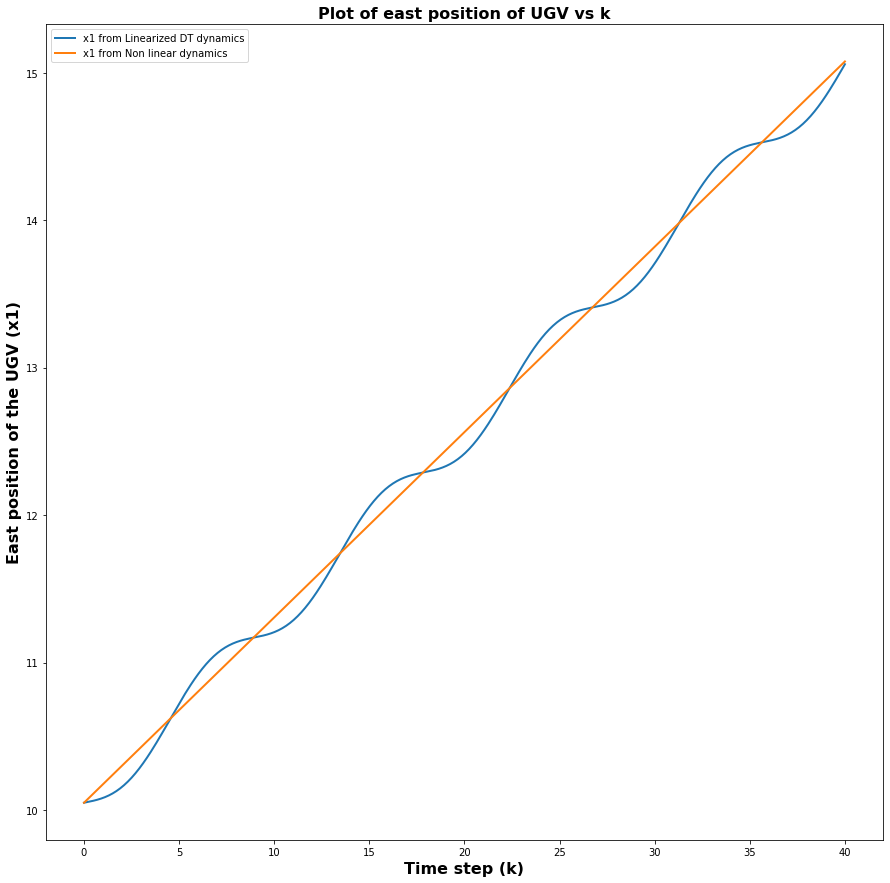

In [9]:
#Plot x[1] or east position of UGV

linearized_DT_x1 = []
non_linear_x1 = []

for state in linearized_DT_states:
    linearized_DT_x1.append(state[0][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x1.append(state[0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UGV (x1)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x1,linewidth = 2,label = 'x1 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x1,linewidth = 2,label = 'x1 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



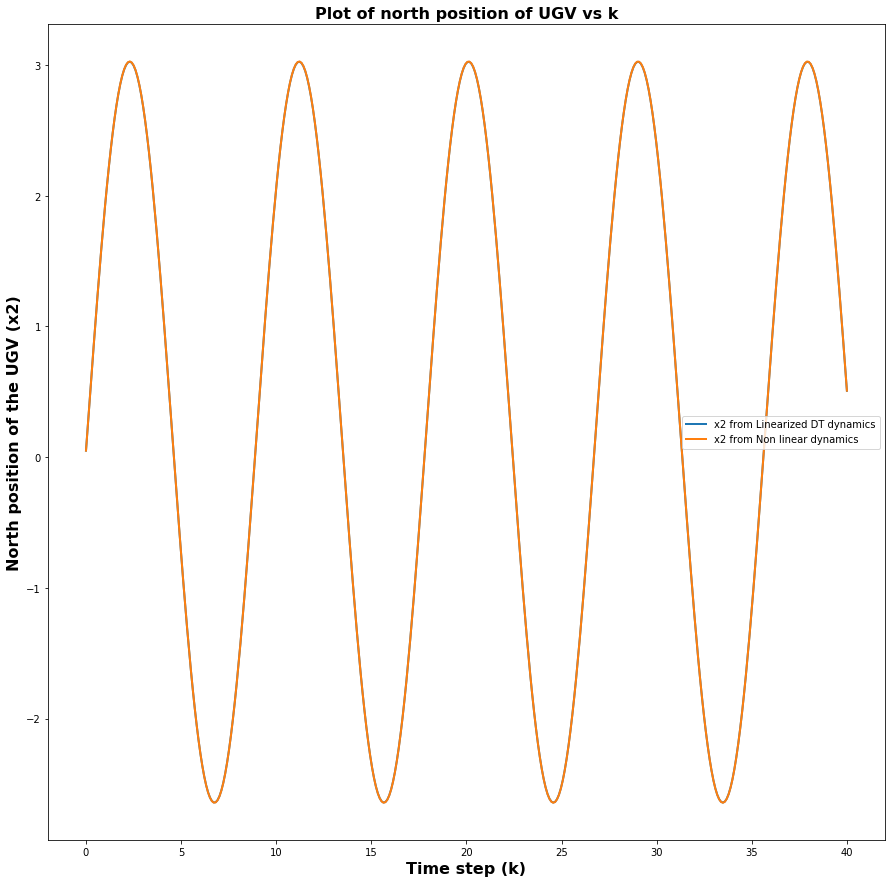

In [10]:
#Plot x[2] or north position of UGV

linearized_DT_x2 = []
non_linear_x2 = []

for state in linearized_DT_states:
    linearized_DT_x2.append(state[1][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x2.append(state[1])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UGV (x2)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x2,linewidth = 2,label = 'x2 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x2,linewidth = 2,label = 'x2 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



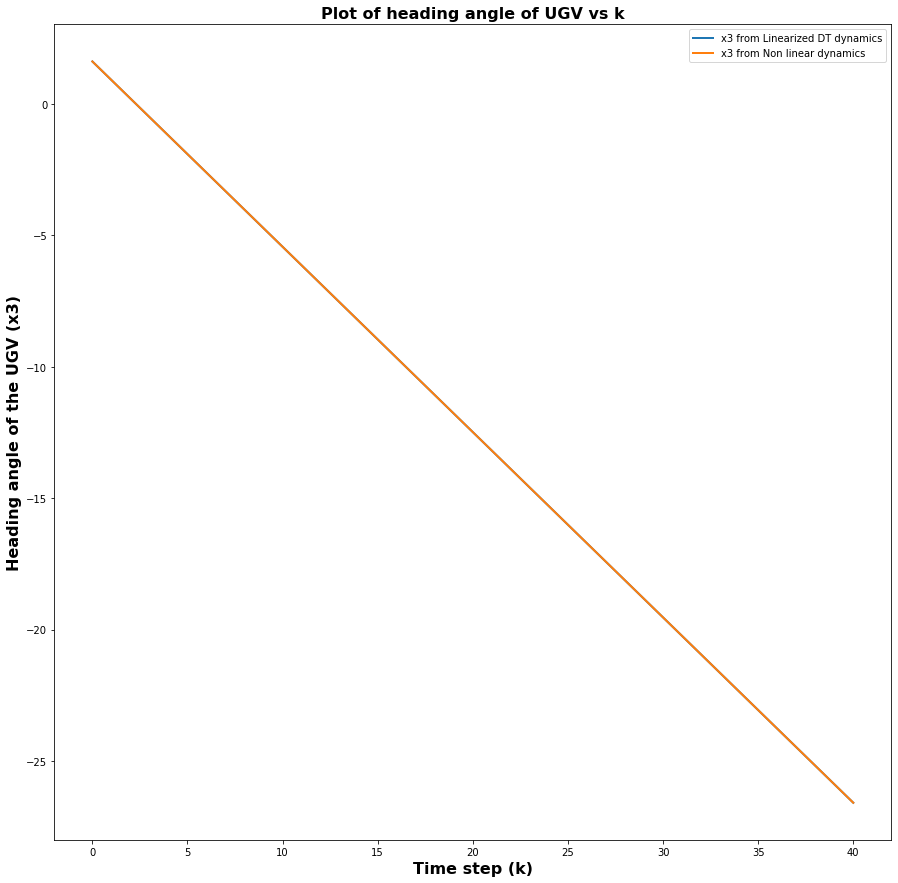

In [11]:
#Plot x[3] or heading angle of UGV

linearized_DT_x3 = []
non_linear_x3 = []

for state in linearized_DT_states:
    linearized_DT_x3.append(state[2][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x3.append(state[2])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UGV (x3)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x3,linewidth = 2,label = 'x3 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x3,linewidth = 2,label = 'x3 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



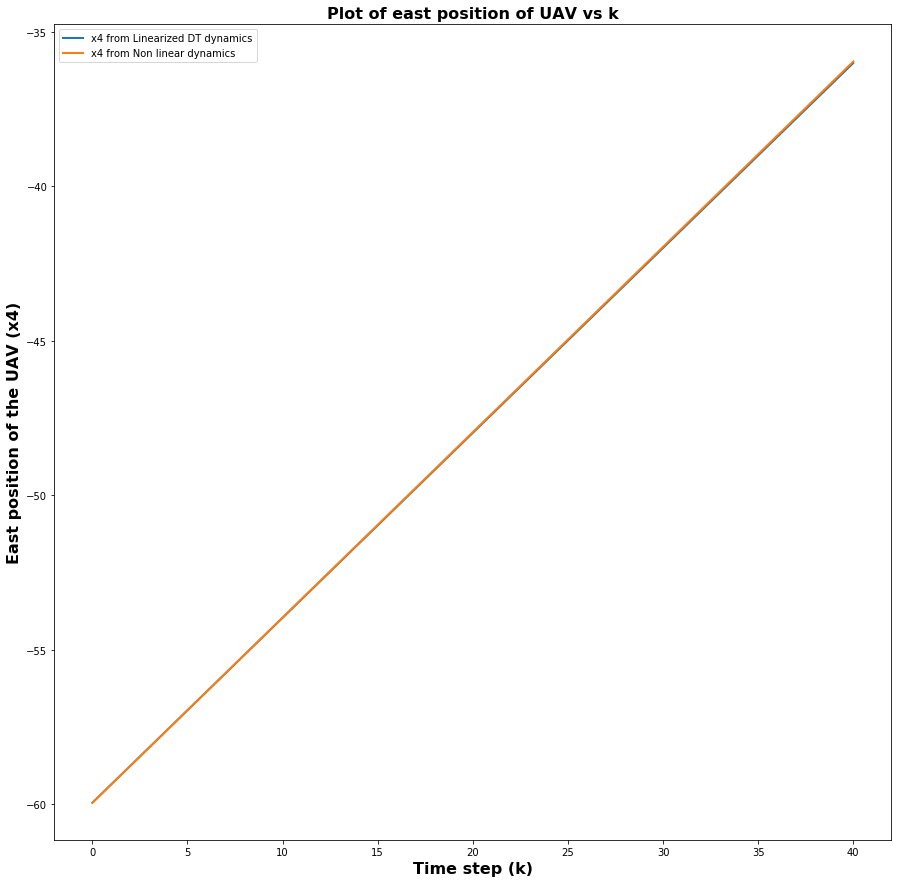

In [12]:
#Plot x[4] or east position of UAV

linearized_DT_x4 = []
non_linear_x4 = []

for state in linearized_DT_states:
    linearized_DT_x4.append(state[3][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x4.append(state[3])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UAV (x4)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x4,linewidth = 2,label = 'x4 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x4,linewidth = 2,label = 'x4 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



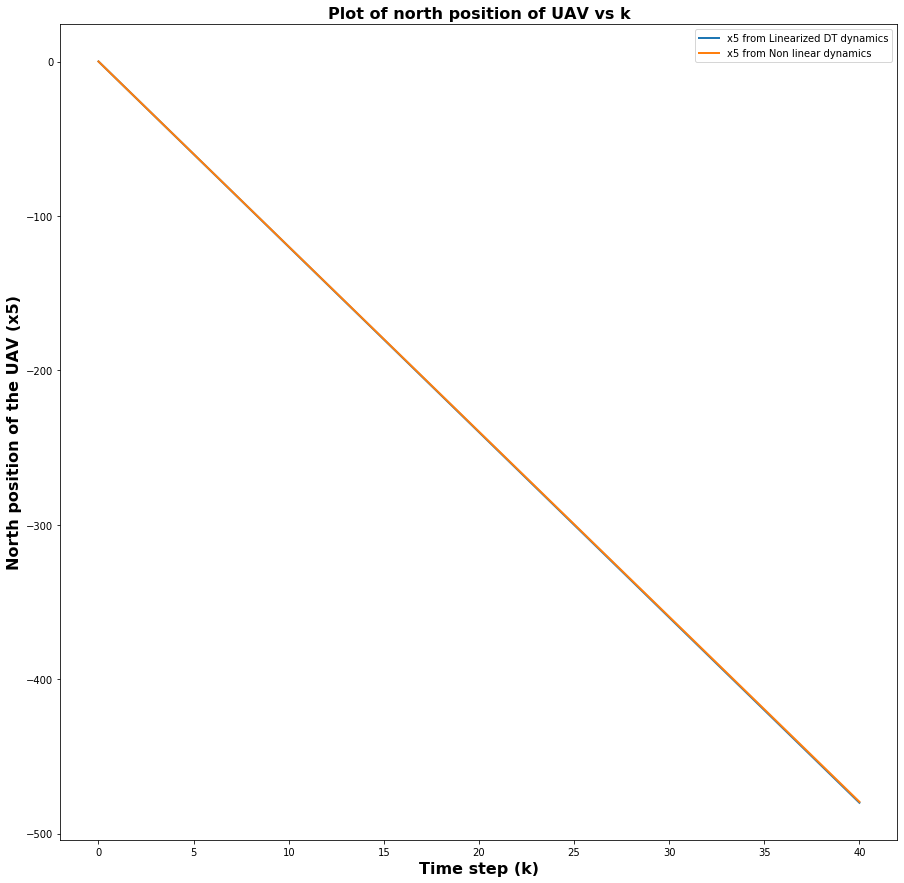

In [13]:
#Plot x[5] or north position of UAV

linearized_DT_x5 = []
non_linear_x5 = []

for state in linearized_DT_states:
    linearized_DT_x5.append(state[4][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x5.append(state[4])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UAV (x5)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x5,linewidth = 2,label = 'x5 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x5,linewidth = 2,label = 'x5 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



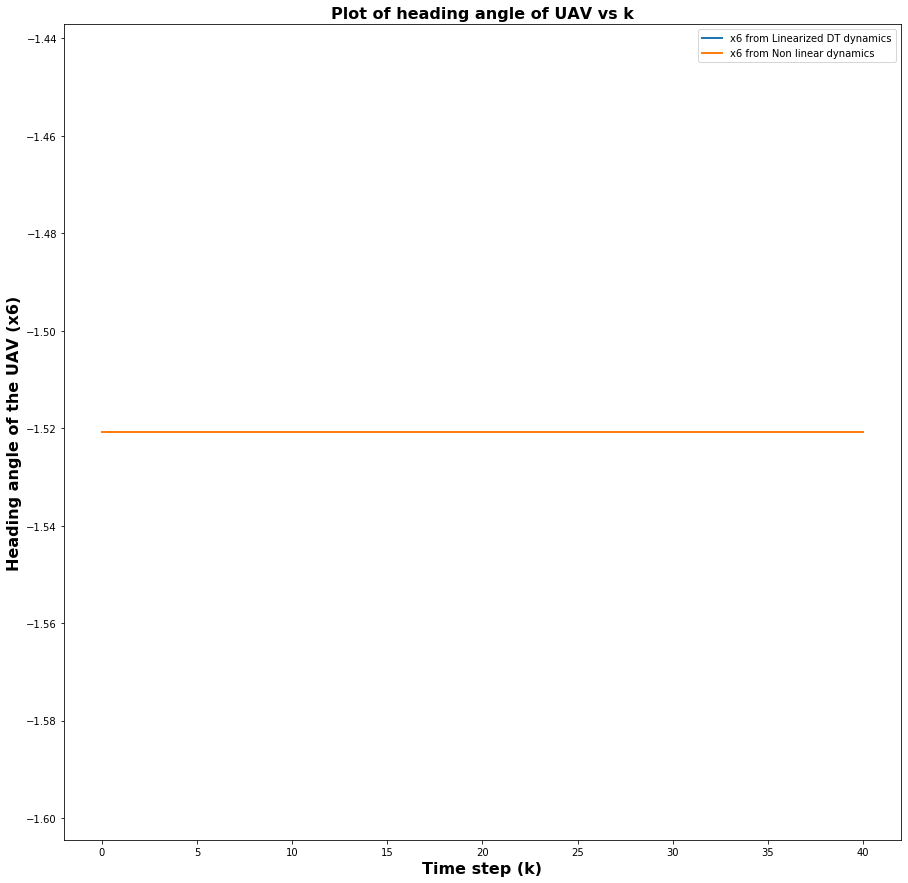

In [14]:
#Plot x[6] or heading angle of UAV

linearized_DT_x6 = []
non_linear_x6 = []

for state in linearized_DT_states:
    linearized_DT_x6.append(state[5][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x6.append(state[5])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UAV (x6)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x6,linewidth = 2,label = 'x6 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x6,linewidth = 2,label = 'x6 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



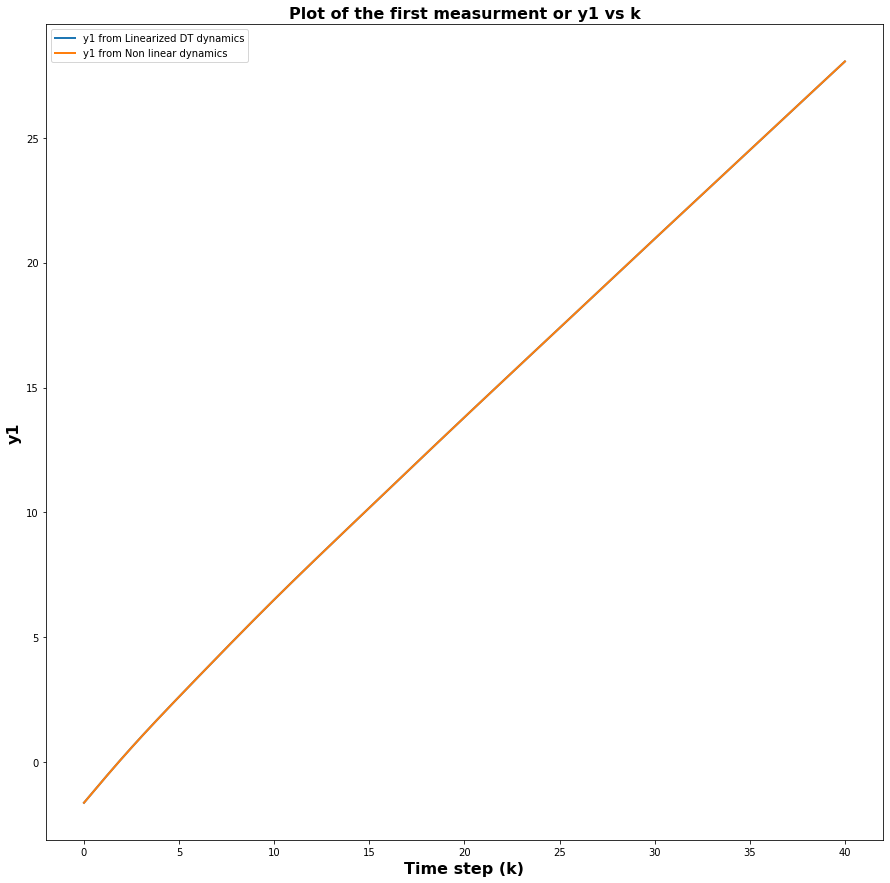

In [15]:
#Plot y[1]

linearized_DT_y1 = []
non_linear_y1 = []

for state in linearized_DT_measurements:
    linearized_DT_y1.append(state[0][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y1.append(state[0][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y1",fontsize=16, fontweight='bold')
plt.title("Plot of the first measurment or y1 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y1,linewidth = 2,label = 'y1 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y1,linewidth = 2,label = 'y1 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



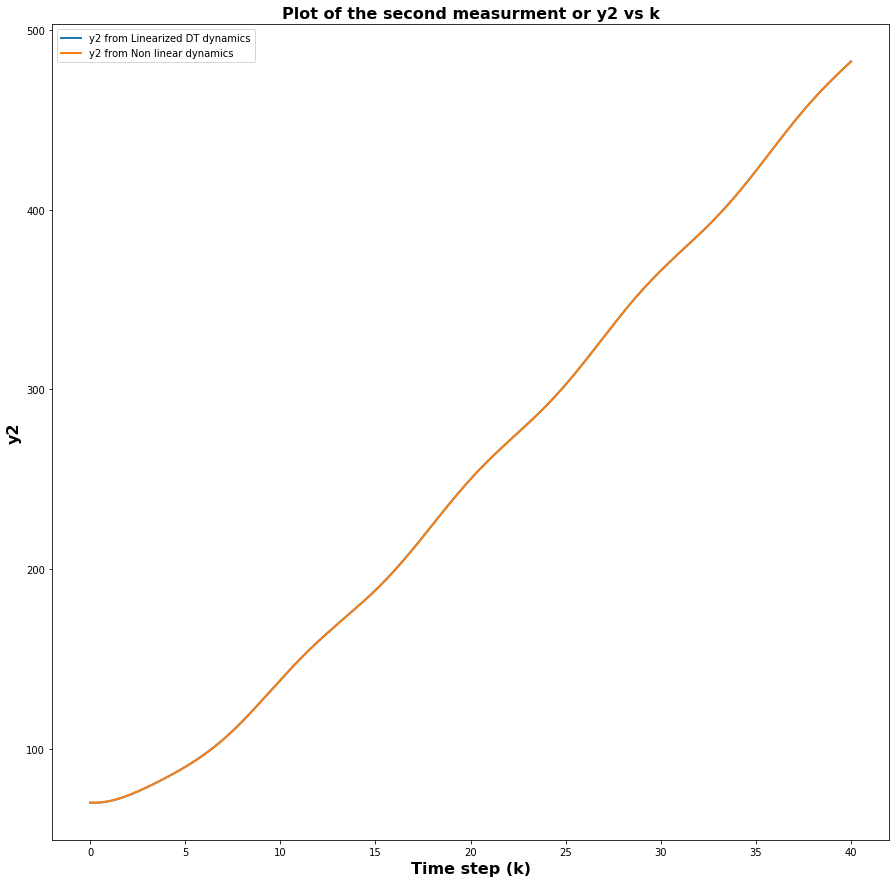

In [16]:
#Plot y[2]

linearized_DT_y2 = []
non_linear_y2 = []

for state in linearized_DT_measurements:
    linearized_DT_y2.append(state[1][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y2.append(state[1][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y2",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y2 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y2,linewidth = 2,label = 'y2 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y2,linewidth = 2,label = 'y2 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



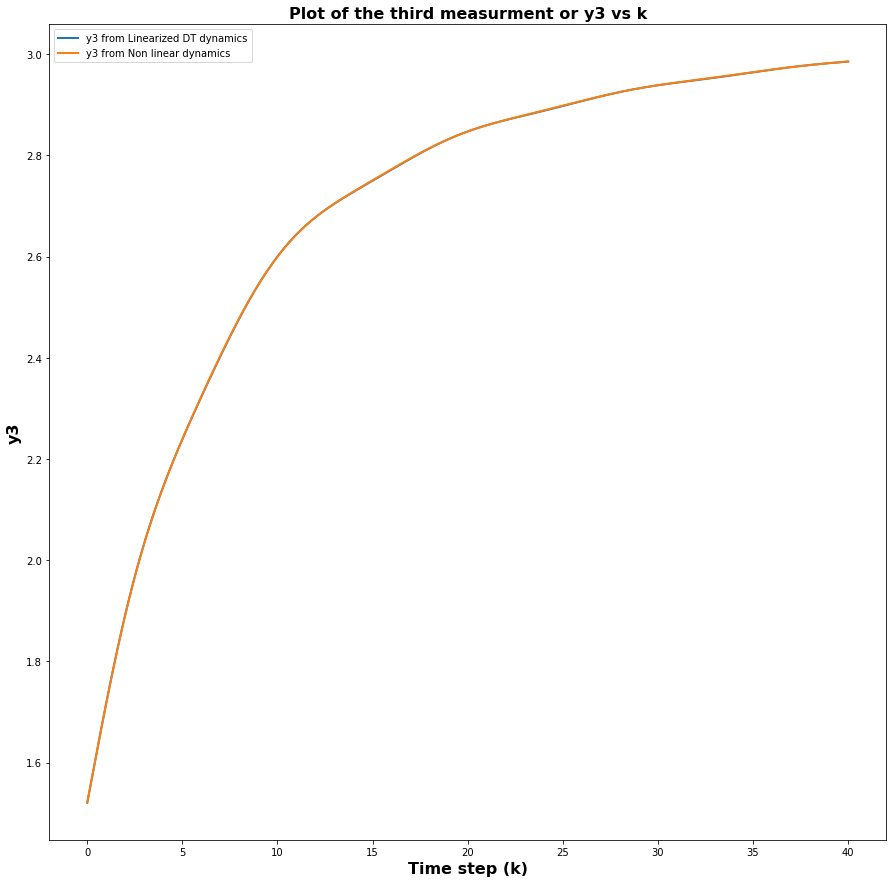

In [17]:
#Plot y[3]

linearized_DT_y3 = []
non_linear_y3 = []

for state in linearized_DT_measurements:
    linearized_DT_y3.append(state[2][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y3.append(state[2][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y3",fontsize=16, fontweight='bold')
plt.title("Plot of the third measurment or y3 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y3,linewidth = 2,label = 'y3 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y3,linewidth = 2,label = 'y3 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



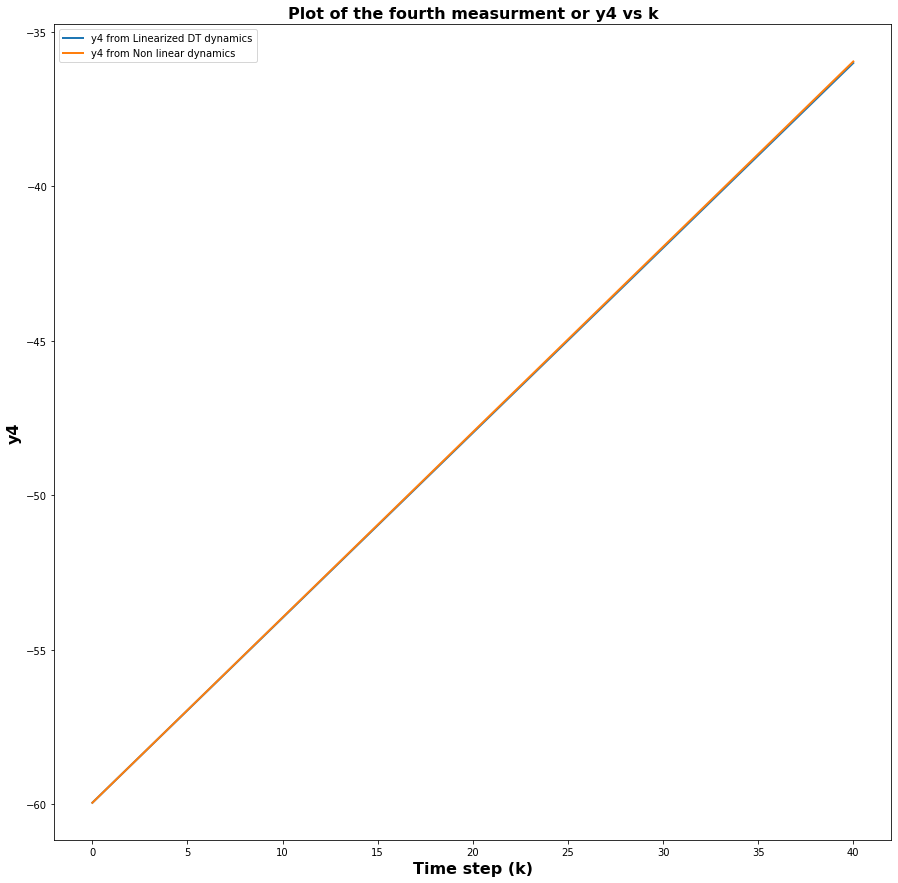

In [18]:
#Plot y[4]

linearized_DT_y4 = []
non_linear_y4 = []

for state in linearized_DT_measurements:
    linearized_DT_y4.append(state[3][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y4.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y4",fontsize=16, fontweight='bold')
plt.title("Plot of the fourth measurment or y4 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y4,linewidth = 2,label = 'y4 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y4,linewidth = 2,label = 'y4 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



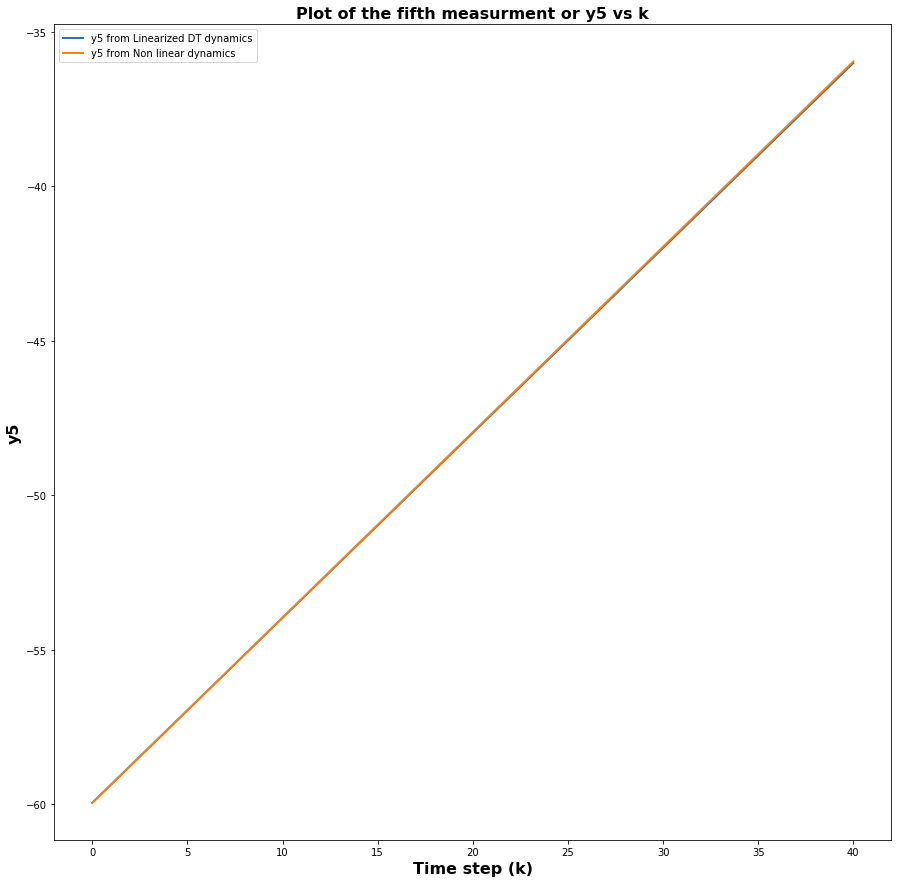

In [20]:
#Plot y[5]

linearized_DT_y5 = []
non_linear_y5 = []

for state in linearized_DT_measurements:
    linearized_DT_y5.append(state[3][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y5.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y5",fontsize=16, fontweight='bold')
plt.title("Plot of the fifth measurment or y5 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y5,linewidth = 2,label = 'y5 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y5,linewidth = 2,label = 'y5 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()

